In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Input  # Add Input
from tensorflow.keras.optimizers import Adam

2025-03-22 10:32:39.619510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 10:32:39.849322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742619759.951633   18436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742619759.977257   18436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 10:32:40.180918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)


In [3]:
diff_close_series = df['Close'].diff().dropna()

# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]

# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.5)
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]


In [4]:
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [5]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [6]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [7]:
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=False))
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


2025-03-22 10:34:06.626804: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=8, verbose=1)


Epoch 1/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0301
Epoch 2/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1380
Epoch 3/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9066
Epoch 4/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0694
Epoch 5/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0388
Epoch 6/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0299
Epoch 7/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1074
Epoch 8/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8084
Epoch 9/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2473
Epoch 10/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1531
Epoch 11/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9858
Epoch 12/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9559
Epoch 13/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0216
Epoch 14/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0544
Epoch 15/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1

In [10]:
y_train_pred_scaled = model.predict(X_train_reshaped)
y_test_pred_scaled = model.predict(X_test_reshaped)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [11]:
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [12]:
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

In [15]:
print(f"Train MSE: {mse_train:.6f}")
print(f"Train R2: {r2_train:.6f}")

Train MSE: 0.084477
Train R2: 0.777308


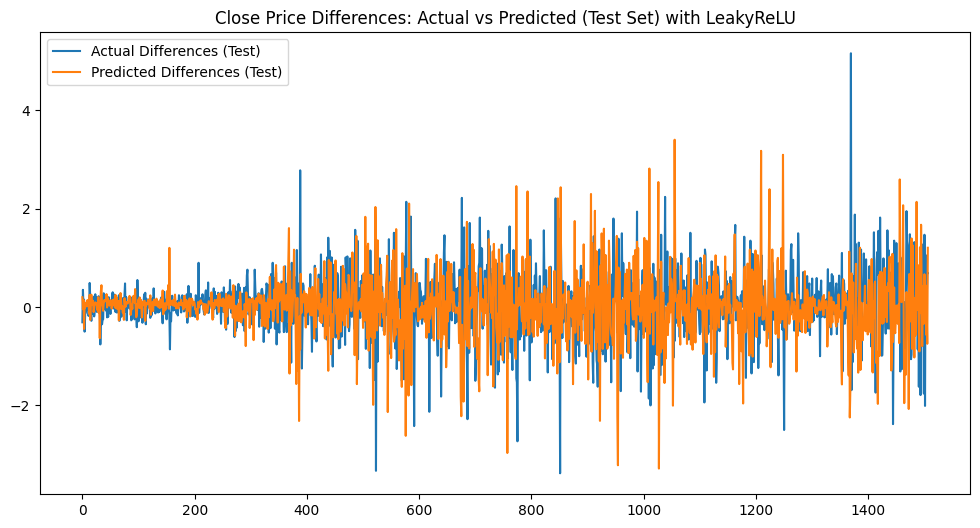

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences (Test)')
plt.plot(y_test_pred, label='Predicted Differences (Test)')
plt.title("Close Price Differences: Actual vs Predicted (Test Set) with LeakyReLU")
plt.legend()
plt.show()